# COMP47590: Advanced Machine Learning
# Assignment 1: Benchmarking Esemble Methods


Student Number(s): 23200361

## Import Packages Etc

In [3]:
import numpy as np
import random
import pandas as pd

from collections import Counter

from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix
from sklearn.datasets import load_iris, load_wine, load_digits, fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import sklearn.utils.validation

# visualisation :

import matplotlib.pyplot as plt
import seaborn as sns

## Task 1: Define HyperParamClassifier

HyperParamClassifier class.

In [11]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class HyperParamEnsembleClassifier(BaseEstimator, ClassifierMixin):

    """An ensemble classifier

    Parameters
    ----------


    Attributes
    ----------


    Notes
    -----


    See also
    --------



    Examples
    --------


    """
    # Constructor for the classifier object
    def __init__(self, base_estimator, param_grid, n_estimators=10, random_state=None ):
        """Setup a HyperParamClassifier classifier .
        Parameters
        ----------



        Returns
        -------
        Nothing
        """

        # Initialise class variabels

        self.base_estimator = base_estimator
        self.param_grid = param_grid
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []
        self.classes_ = None


    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a HyperParamClassifier classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples.
        y : array-like, shape = [n_samples]
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """
        X, y = sklearn.utils.validation.check_X_y(X, y)

        self.random_state_ = sklearn.utils.validation.check_random_state(self.random_state)

        self.classes_ = np.unique(y)

        param_combinations = [
            {key: self.random_state_.choice(values) for key, values in self.param_grid.items()}
            for _ in range(self.n_estimators)
        ]

        self.models = []

        for params in param_combinations:
            model = clone(self.base_estimator)
            model.set_params(**params)
            model.fit(X, y)
            self.models.append(model)

        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples.
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples.
        """

        sklearn.utils.validation.check_is_fitted(self, ['models'])

        X = sklearn.utils.validation.check_array(X)

        predictions = np.array([model.predict(X) for model in self.models])

        prediction = np.apply_along_axis(lambda row: Counter(row).most_common(1)[0][0], axis=0, arr=predictions)

        # Return the prediction made by the classifier
        return prediction

    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):

        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples.
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples.
        """
        sklearn.utils.validation.check_is_fitted(self, ['models'])

        X = sklearn.utils.validation.check_array(X)

        valid_models = [model for model in self.models if hasattr(model, "predict_proba")]

        if not valid_models:
            raise ValueError("No models in the ensemble support probability prediction.")

        all_classes = self.classes_

        class_index = {cls: i for i, cls in enumerate(all_classes)}

        adjusted_probabilities = []

        for model in valid_models:
            model_probability = np.zeros((X.shape[0], len(all_classes)))

            for i, cls in enumerate(model.classes_):
                model_probability[:, class_index[cls]] = model.predict_proba(X)[:, i]

            adjusted_probabilities.append(model_probability)

        # Return the prediction made by the classifier
        return np.mean(adjusted_probabilities, axis=0)

## Task 2: Design the Evaluation Experiment

Describe datasets and expeimental apporach and setup infrastructure for experimentation.

In [12]:

# downloading the mnist dataset:
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

 # we are limiting the sample due to speed/ efficiency
X_mnist, y_mnist = X_mnist[:2000], y_mnist[:2000]

 # convert labels to integers
y_mnist = y_mnist.astype(int)

datasets = {
    "Iris": load_iris(),
    "Wine": load_wine(),
    "Digits": load_digits(),
    "MNIST": {"data": X_mnist, "target": y_mnist}
}

# standars scalar to standardise the datasets:
scaler = StandardScaler()

for name, dataset in datasets.items():
    if isinstance(dataset, dict):
        dataset["data"] = scaler.fit_transform(dataset["data"])
    else:
        dataset.data = scaler.fit_transform(dataset.data)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

baseline_models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

performance_metrics = {
    "Accuracy": accuracy_score,
    "Macro F1-Score": lambda y_true, y_pred: f1_score(y_true, y_pred, average="macro"),
    "Log Loss": log_loss,
    "Confusion Matrix": confusion_matrix
}

param_grid = {
    "max_depth": [3, 5, 10],
    "min_samples_split": [2, 4, 6]
}

## Task 3: Execute Evalution Experiment

In [13]:
#evaluate the models and perform cross-validation.

def evaluate_model(model, X, y, cv, metrics):
    results = {}
    y_pred = cross_val_predict(model, X, y, cv=cv)

    print(f"\nEvaluating {type(model).__name__}")
    print(f"Classes in y_true: {np.unique(y)}")
    print(f"Classes in y_pred: {np.unique(y_pred)}")

    try:
        y_proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba")
    except ValueError:
        y_proba = None

    for metric_name, metric_func in metrics.items():
        if metric_name == "Confusion Matrix":
            results[metric_name] = metric_func(y, y_pred)
        elif metric_name == "Log Loss" and y_proba is not None:
            results[metric_name] = metric_func(y, y_proba, labels=np.unique(y))
        else:
            results[metric_name] = metric_func(y, y_pred)

    return results

# run the evaluation  for the ensemble and baseline models(4)
ensemble_results = {}
baseline_results = {}

for dataset_name, dataset in datasets.items():
    if isinstance(dataset, dict):
        X, y = dataset["data"], dataset["target"]
    else:
        X, y = dataset.data, dataset.target

    print(f"\n evaluating the ensemble model on {dataset_name}")

    ensemble_model = HyperParamEnsembleClassifier(
        base_estimator=DecisionTreeClassifier(),
        param_grid={"max_depth": [3, 5, 10], "min_samples_split": [2, 4, 6]},
        n_estimators=5
    )
    ensemble_results[dataset_name] = evaluate_model(ensemble_model, X, y, cv, performance_metrics)

    baseline_results[dataset_name] = {}

    for name, model in baseline_models.items():
        print(f"\nevaluating {name} on {dataset_name}")
        baseline_results[dataset_name][name] = evaluate_model(model, X, y, cv, performance_metrics)

# print the results
ensemble_df = pd.DataFrame(ensemble_results).T
baseline_df = {model: pd.DataFrame({dataset: scores[model] for dataset, scores in baseline_results.items()}).T for model in baseline_models.keys()}

print("\n the ensemble model  :")
print(ensemble_df)

print("\n the ensemble model  :")
for model, df in baseline_df.items():
    print(f"\n{model} performance:")
    print(df)



evaluating the ensemble model on Iris

Evaluating HyperParamEnsembleClassifier
Classes in y_true: [0 1 2]
Classes in y_pred: [0 1 2]

evaluating Decision Tree on Iris

Evaluating DecisionTreeClassifier
Classes in y_true: [0 1 2]
Classes in y_pred: [0 1 2]

evaluating Random Forest on Iris

Evaluating RandomForestClassifier
Classes in y_true: [0 1 2]
Classes in y_pred: [0 1 2]

evaluating Support Vector Machine on Iris

Evaluating SVC
Classes in y_true: [0 1 2]
Classes in y_pred: [0 1 2]

evaluating Logistic Regression on Iris

Evaluating LogisticRegression
Classes in y_true: [0 1 2]
Classes in y_pred: [0 1 2]

evaluating K-Nearest Neighbors on Iris

Evaluating KNeighborsClassifier
Classes in y_true: [0 1 2]
Classes in y_pred: [0 1 2]

evaluating the ensemble model on Wine

Evaluating HyperParamEnsembleClassifier
Classes in y_true: [0 1 2]
Classes in y_pred: [0 1 2]

evaluating Decision Tree on Wine

Evaluating DecisionTreeClassifier
Classes in y_true: [0 1 2]
Classes in y_pred: [0 1 2

### Experiment Results Summary
Present a series of tables and graphs illustraitng experiment results.

<ipython-input-14-d72c1d914207>:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  accuracy_df = pd.concat(


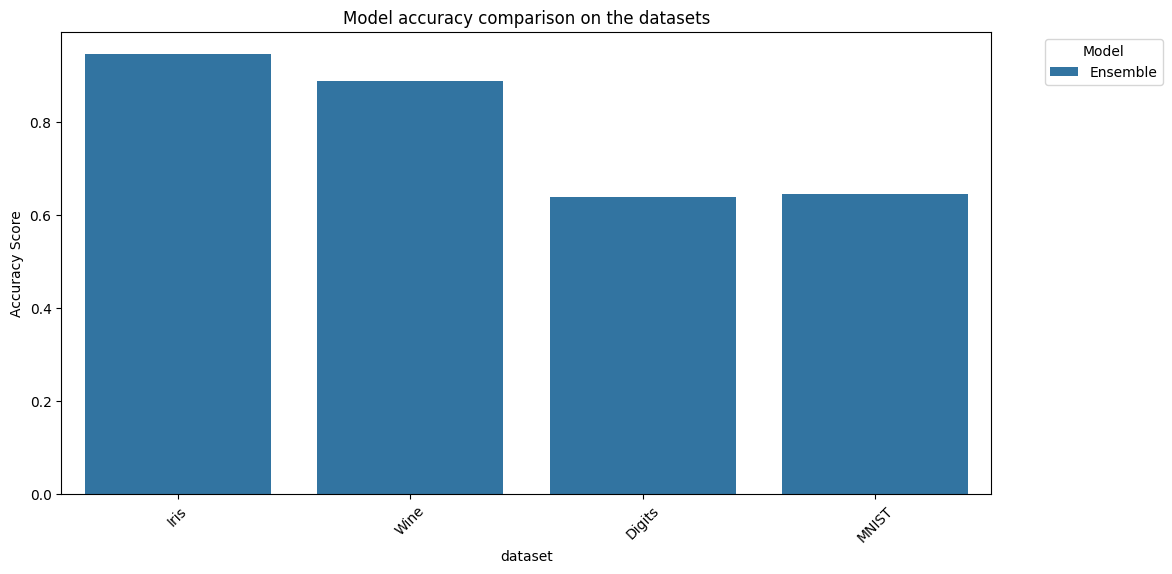

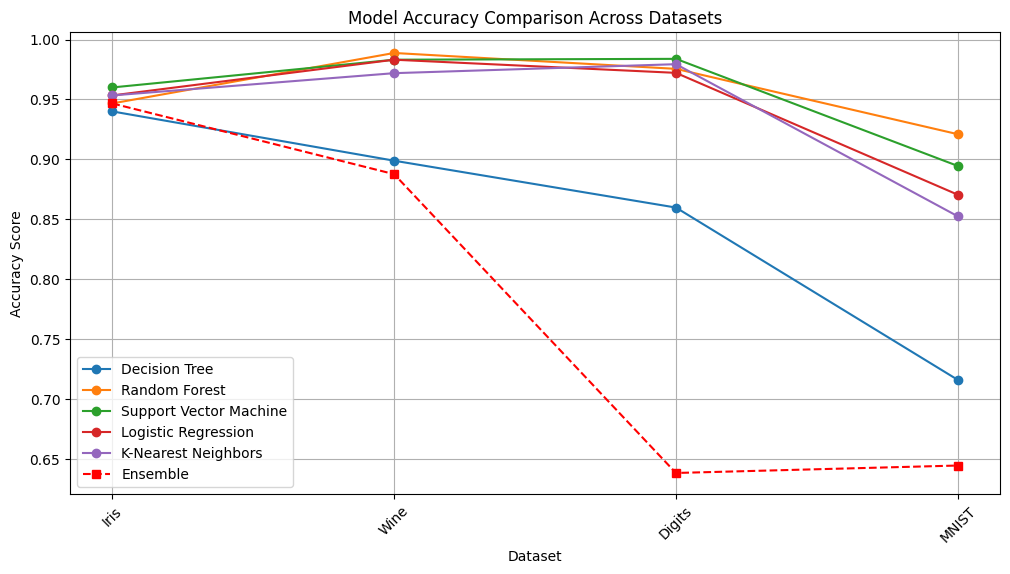


Confusion Matrices for Iris:


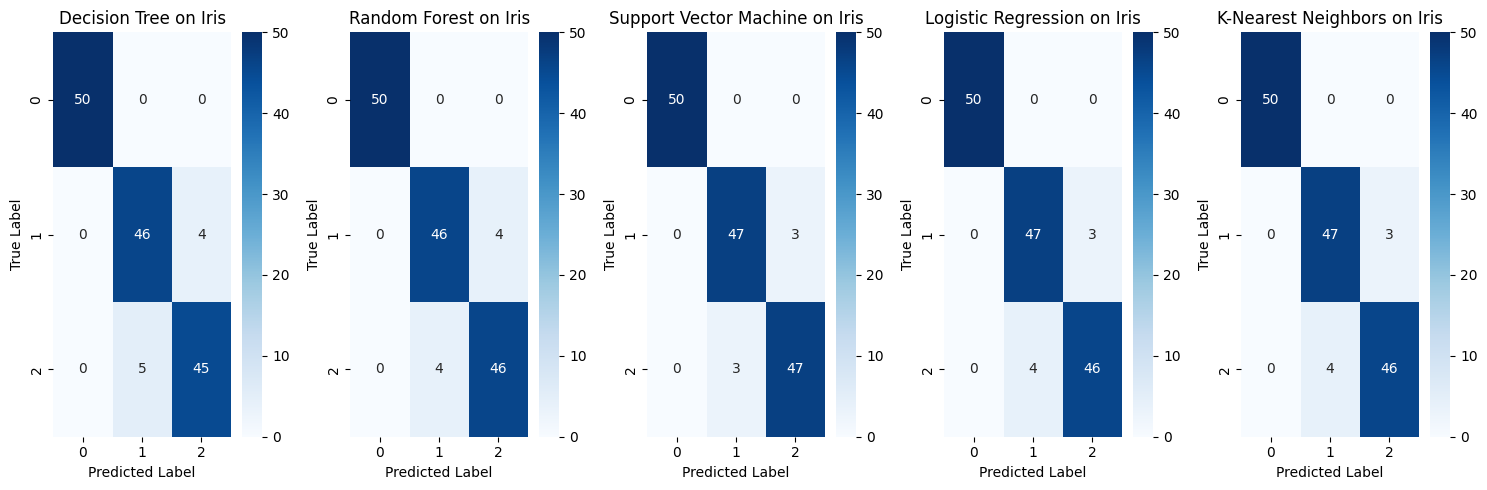


Confusion Matrices for Wine:


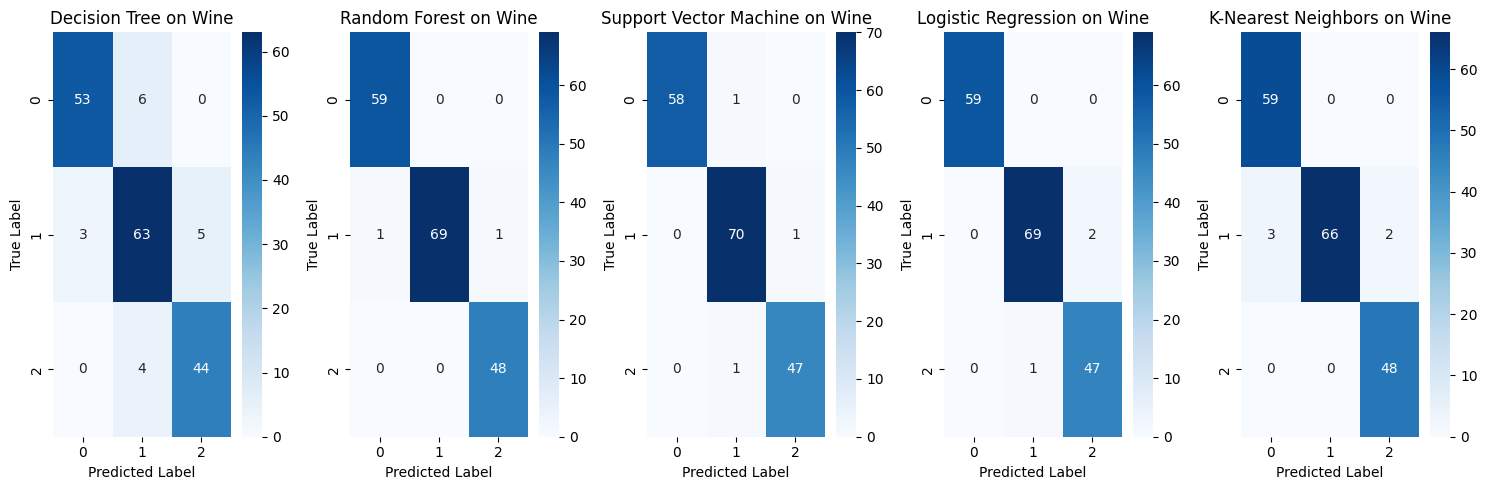


Confusion Matrices for Digits:


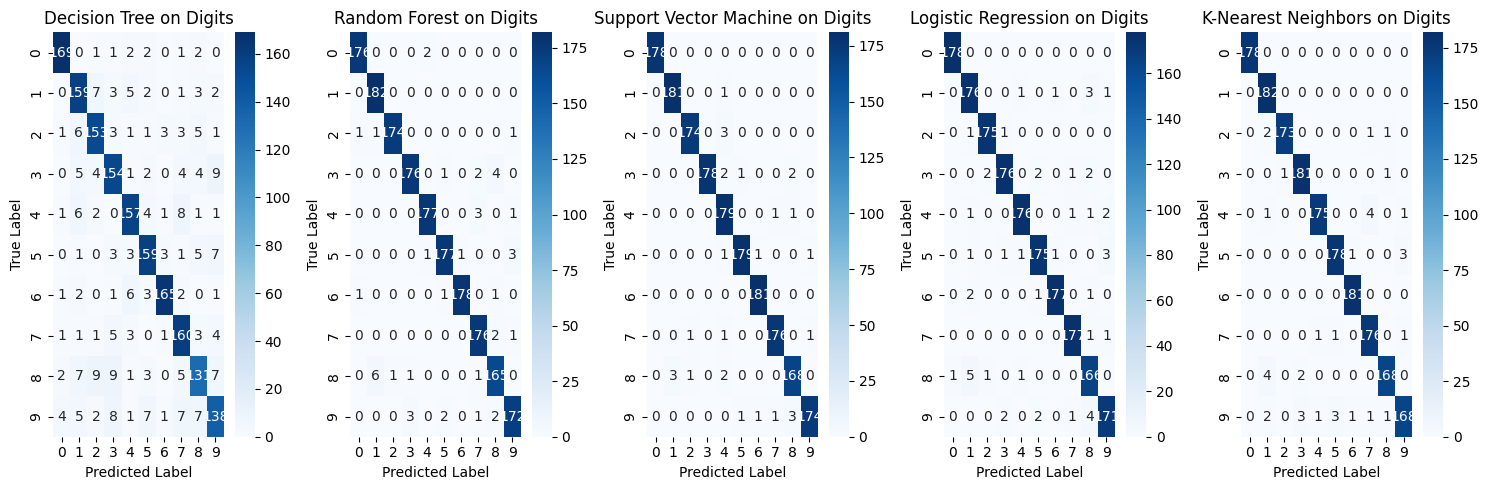


Confusion Matrices for MNIST:


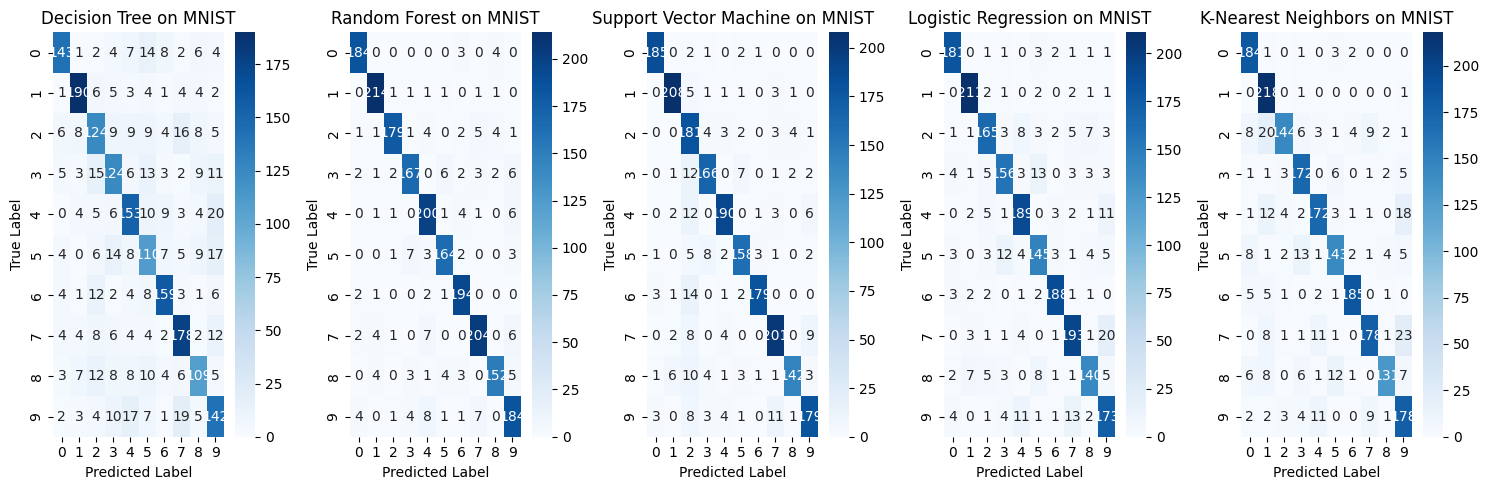


Confusion Matrix for Ensemble Model on Iris:


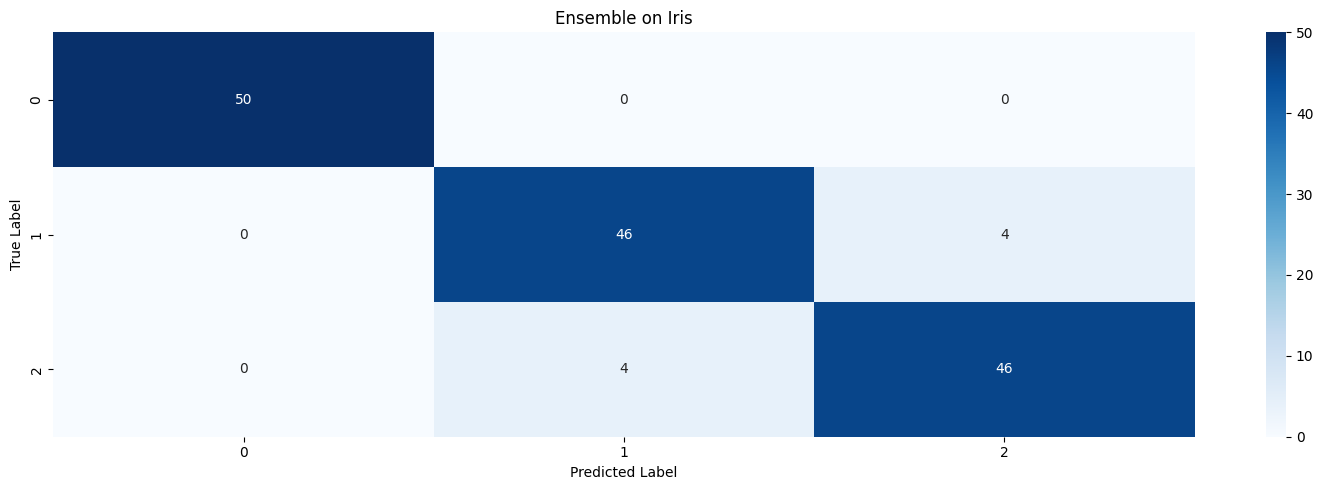


Confusion Matrix for Ensemble Model on Wine:


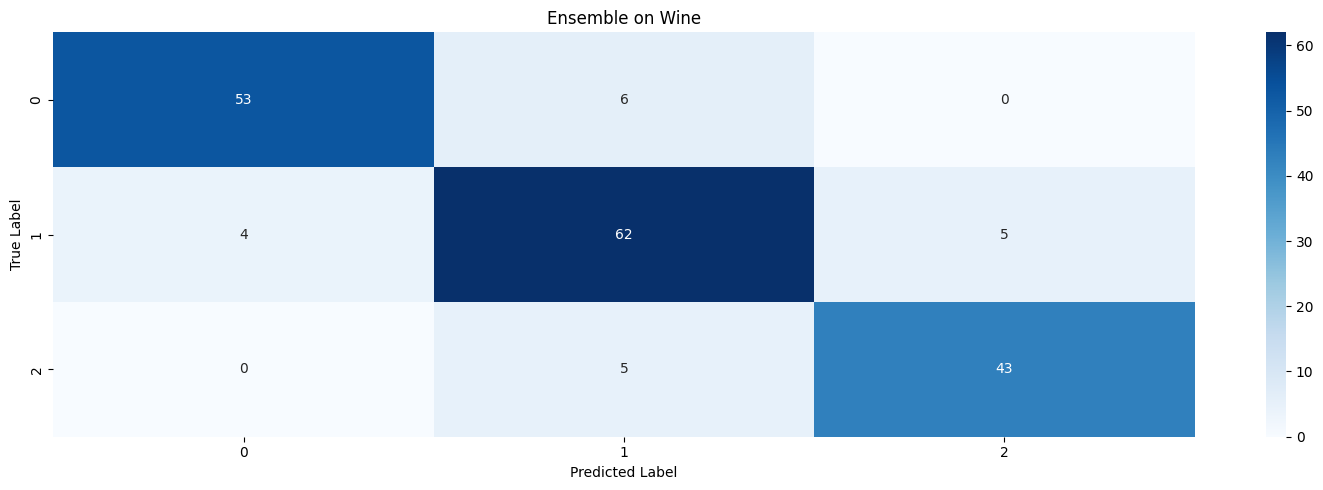


Confusion Matrix for Ensemble Model on Digits:


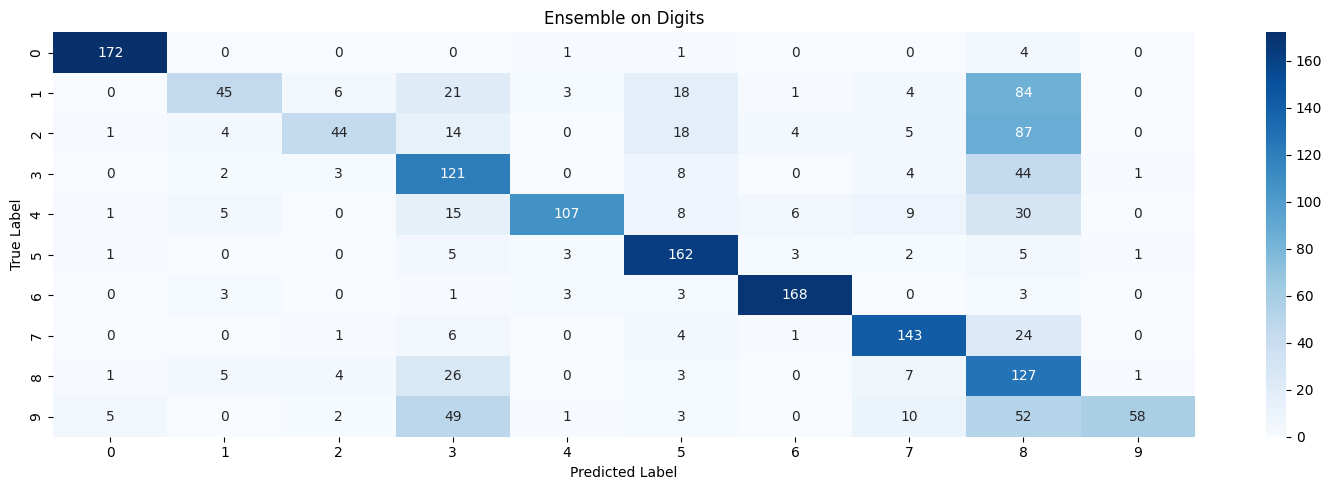


Confusion Matrix for Ensemble Model on MNIST:


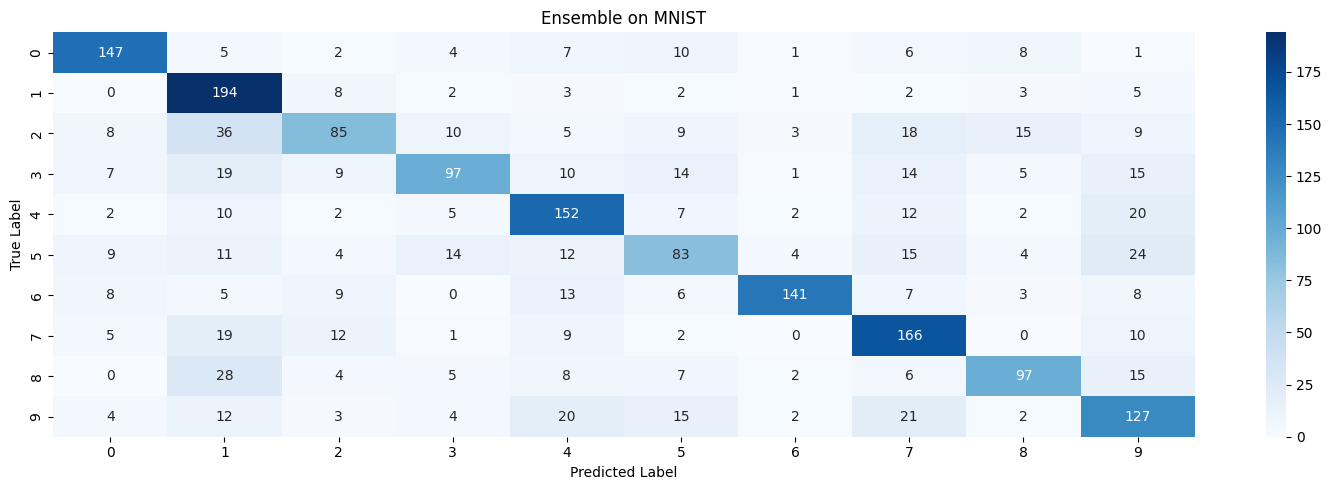

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt


# convert the results into a df to use:

accuracy_df = pd.DataFrame(columns=["Dataset", "Model", "Accuracy"])

for dataset, results in ensemble_results.items():
    if "Accuracy" in results:
        accuracy_df = pd.concat(
            [accuracy_df, pd.DataFrame([{"Dataset": dataset, "Model": "Ensemble", "Accuracy": results["Accuracy"]}])],
            ignore_index=True
        )
    for model_name, model_results in baseline_results[dataset].items():
        if "Accurcy" in model_results:
            accuracy_df = pd.concat(
                [accuracy_df, pd.DataFrame([{"Dataset": dataset, "Model": model_name, "Accuracy": model_results["Accuracy"]}])],
                ignore_index=True
            )


# A bar Chart: comparing accuracy across the mdels and the datasets


plt.figure(figsize=(12, 6))
sns.barplot(x="Dataset", y="Accuracy", hue="Model", data=accuracy_df)
plt.title("Model accuracy comparison on the datasets")
plt.xticks(rotation=45)
plt.ylabel("Accuracy Score")
plt.xlabel("dataset")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# A line Chart:


plt.figure(figsize=(12, 6))


for model_name in baseline_models.keys():
    model_accuracies = [baseline_results[dataset][model_name]["Accuracy"] for dataset in datasets.keys()]
    plt.plot(datasets.keys(), model_accuracies, label=model_name, marker='o')

# plot the ensemble
ensemble_accuracies = [ensemble_results[dataset]["Accuracy"] for dataset in datasets.keys()]
plt.plot(datasets.keys(), ensemble_accuracies, label="Ensemble", marker='s', linestyle='--', color='red')

plt.title("Model Accuracy Comparison Across Datasets")
plt.xlabel("Dataset")
plt.ylabel("Accuracy Score")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()


# convert the confusion matrix to heatmaps

# plot  the  heatmaps
def plot_confusion_matrices(results, dataset_name):
    models = list(results.keys())
    fig, axes = plt.subplots(1, len(models), figsize=(15, 5))

    for i, (model_name, model_results) in enumerate(results.items()):
        if "Confusion Matrix" in model_results:
            ax = axes[i] if len(models) > 1 else axes
            sns.heatmap(model_results["Confusion Matrix"], annot=True, fmt="d", cmap="Blues", ax=ax)
            ax.set_title(f"{model_name} on {dataset_name}")
            ax.set_xlabel("Predicted Label")
            ax.set_ylabel("True Label")

    plt.tight_layout()
    plt.show()


for dataset_name, dataset_results in baseline_results.items():
    print(f"\nConfusion Matrices for {dataset_name}:")
    plot_confusion_matrices(dataset_results, dataset_name)

for dataset_name, results in ensemble_results.items():
    if "Confusion Matrix" in results:
        print(f"\nConfusion Matrix for Ensemble Model on {dataset_name}:")
        plot_confusion_matrices({"Ensemble": results}, dataset_name)


## Task 4: Reflection
A short (less than 400 words) reflection on the results of the experiment and the experience of running it.


The ensemble model shows that it performed well on the smaller datasets (the
Iris and the wine dataset) but it appeared to not perform as well on the larger ones (the Digits and the Mnist datasets). You can see this pattern throughpt the graphs and the visualisations.

It is evident in the accuracy trend graph, when you can see that it, the ensemble, stays at a high accuracy  between 0.94 - 0.95 but then does drop significantly for the  larger datasets as already discussed.

This suggests to us that a few factors are impacting/ influencing the performance of the ensemble:

Overfitting:

* The model did well on the smaller and simpler datasets, because they have less features and they are less complex. But when it came to the larger datasets it seemed to struggle to generalise. which means that it performed well on the training data, but not on the unseen data.

Issues wwith hyperparameter tuning :

* The ensemble model works by training multiple models with different hyperparameters,which leads to some models performing well, but others might either underfit or overfit which reduces the stability overall.

* High differences/ variations in hyperparameters might cuase some models to be overly complex while others are too simple, which also reduces the effectiveness.

* What we have seen is that small datasets can handle the variations in the hyperparameters, while larger datasets need more precise tuning to try avoid low performance.

Model choice / design :
*  The base model for the ensemble was a decision tree, and if the trees were too simple (shallow) , then they are unlikely to capture patterns that are more complex in the large datasets.

*   However, if the trees are too complex, then there is a possibility that they could have memorised the training data instead of learning patterns which ultimately leads to it not performibg well on new data.

Key Insights :

* The ensemble model performed well for simpler datasets but it struggled with more complex and high-dimensional data.

* It indicates to us that different datasets might require different approaches/ strategies because more comlex data might need deeper models, or different base models ( such as Random Forest) or, they need better hyperparameter tuning.

What could be done in the future:

* The number of models in the ensemble can be increased
* The hyperparameters for larger datasets could be furhter adjusted/configured.
* Alternative classifier models could be chosen as the base model.



In [ ]:
!jupyter nbconvert --to html /path/to/your/notebook.ipynb
